In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

X[1:,:] = (X[1:,:] - X[1:,:].mean(axis=1).reshape([3, 1])) / X[1:,:].std(axis=1).reshape([3, 1])

#### Задание 1
Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.

In [3]:
def calc_logloss(y, y_pred, epsilon = 1e-12):    
    y_pred[y_pred==0] += epsilon
    y_pred[y_pred==1] -= epsilon
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

#### Задание 2
Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [4]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [5]:
def eval_model(X, y, iterations, alpha=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    err_history = []
    min_err = 100
    n_iter = None
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
        
        if err < min_err:
            n_iter, min_err = i, err
        err_history.append(err)
    print(f'Min(log_loss) at learning_rate={alpha} is {round(min_err, 4)}, at {n_iter} iterations')
    return W, err_history

In [6]:
def plot (t, alpha_list, model=eval_model):
    dots = np.linspace(0, t, t)
    plt.xlabel('Number of inerations')
    plt.ylabel('Error')


    for alpha in alpha_list:
        _, err_history = model(X, y, t, alpha)
        plt.plot(dots, err_history)

    plt.legend(['alpha=' + str(i) for i in alpha_list])
    plt.show()

Min(log_loss) at learning_rate=29.5 is 0.0173, at 1000 iterations
Min(log_loss) at learning_rate=29.45 is 0.0171, at 1000 iterations
Min(log_loss) at learning_rate=29.4 is 0.0172, at 1000 iterations
Min(log_loss) at learning_rate=1 is 0.1791, at 1000 iterations
Min(log_loss) at learning_rate=0.1 is 0.3101, at 1000 iterations
Min(log_loss) at learning_rate=0.01 is 0.4613, at 1000 iterations


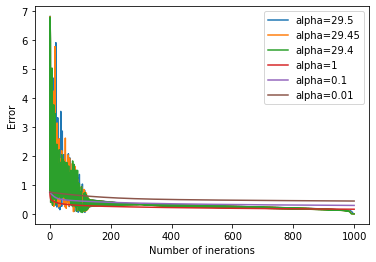

In [7]:
t = 1000
alpha_list = [29.5, 29.45, 29.4, 1, 1e-1,  1e-2]
plot (t, alpha_list)

#### Задание 3
Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

In [8]:
def calc_pred_proba(W, X):
    z = np.dot(W, X)
    y_pred_proba = sigmoid(z)
    return y_pred_proba

#### Задание 4
Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).

In [9]:
def calc_pred(W, X, split_level=0.5):
    z = np.dot(W, X)
    y_pred = sigmoid(z)    
    y_pred[y_pred >= split_level] = 1
    y_pred[y_pred < split_level] = 0
    return y_pred

#### Задание 5
Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

In [10]:
def metrics(y, y_pred):    
    accuracy = ((y-y_pred)==0).sum() / len(y)

    TP = y[(y - y_pred) == 0].sum()
    FP = ((y - y_pred) == -1).sum()
    TN = (y[(y - y_pred) == 0]==0).sum()
    FN = ((y - y_pred) == 1).sum()

    print(f'\nМатрица ошибок\n\t1\t0\n1:\t{int(TP)}\t{FP}\n0:\t{FN}\t{TN}\n')

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1_score = 2 * precision * recall / (precision + recall)

    print(f'accuracy = {accuracy}')
    print(f'precision = {round(precision, 2)}')
    print(f'recall = {recall}')
    print(f'F1_score = {round(F1_score, 2)}')

In [11]:
W, _ = eval_model(X, y, iterations=1000, alpha=29.45)
y_pred = calc_pred(W, X)

metrics(y, y_pred)

Min(log_loss) at learning_rate=29.45 is 0.0171, at 1000 iterations

Матрица ошибок
	1	0
1:	5	0
0:	0	5

accuracy = 1.0
precision = 1.0
recall = 1.0
F1_score = 1.0


#### Задание 6
Могла ли модель переобучиться? Почему? 

Модель могла переобучиться. 10 объектов может оказаться слишком мало и модель могла наренироваться именно на эти объекты, а на тестовом датасете показать гораздо хушие результаты.

#### Задание 7*
Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

##### L1-регуляризация

In [12]:
def eval_model_L1(X, y, iterations, alpha=1e-4, lambda_=0.75):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    err_history = []
    min_err = 100
    n_iter = None
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * 1/n * (np.dot((y_pred - y), X.T)+ lambda_ * np.sign(W))
        
        if err < min_err:
            n_iter, min_err = i, err
        err_history.append(err)
    print(f'Min(log_loss) at learning_rate={alpha} is {round(min_err, 2)}, at {n_iter} iterations')
    return W, err_history

Min(log_loss) at learning_rate=29.4 is 0.26, at 47 iterations
Min(log_loss) at learning_rate=0.4 is 0.54, at 15 iterations
Min(log_loss) at learning_rate=0.1 is 0.54, at 53 iterations


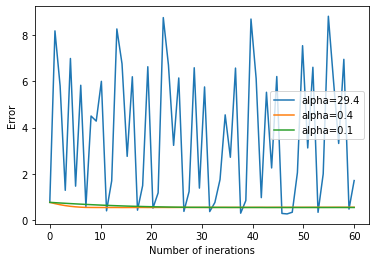

In [13]:
t = 60
alpha_list = [29.4, 4e-1, 1e-1]
plot (t, alpha_list, model=eval_model_L1)

In [14]:
W, _ = eval_model_L1(X, y, iterations=47, alpha=29.4)
y_pred = calc_pred(W, X)

metrics(y, y_pred)

Min(log_loss) at learning_rate=29.4 is 0.26, at 47 iterations

Матрица ошибок
	1	0
1:	4	0
0:	1	5

accuracy = 0.9
precision = 1.0
recall = 0.8
F1_score = 0.89


##### L2-регуляризация

In [15]:
def eval_model_L2(X, y, iterations, alpha=1e-4, lambda_=0.75):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]    
    
    err_history = []
    min_err = 100
    n_iter = None
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * 1/n * (np.dot((y_pred - y), X.T)+ lambda_ * W)
        
        if err < min_err:
            n_iter, min_err = i, err
        err_history.append(err)
    print(f'Min(log_loss) at learning_rate={alpha} is {round(min_err, 4)}, at {n_iter} iterations')
    return W, err_history

Min(log_loss) at learning_rate=2.8 is 0.5295, at 649 iterations
Min(log_loss) at learning_rate=2.7 is 0.5251, at 41 iterations
Min(log_loss) at learning_rate=2.6 is 0.5252, at 21 iterations
Min(log_loss) at learning_rate=0.1 is 0.5253, at 1000 iterations


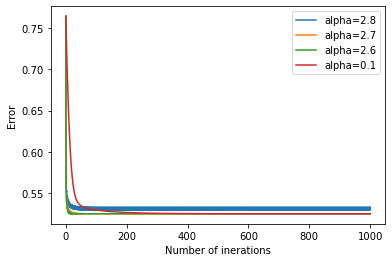

In [16]:
t = 1000
alpha_list = [2.8, 2.7, 2.6, 1e-1]
plot (t, alpha_list, model=eval_model_L2)

In [17]:
W, _ = eval_model_L2(X, y, iterations=41, alpha=2.7)
y_pred = calc_pred(W, X)

metrics(y, y_pred)

Min(log_loss) at learning_rate=2.7 is 0.5251, at 41 iterations

Матрица ошибок
	1	0
1:	4	0
0:	1	5

accuracy = 0.9
precision = 1.0
recall = 0.8
F1_score = 0.89


Применение регулризации повышет уровень ошибки, но позволет уменьшить переобучение модели.